#Deep Learning con Python
`Autor: Erwing FC 
~erwingforerocastro@gmail.com`

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print(train_data.shape)
print(test_data.shape)
print(train_targets[:10])

(404, 13)
(102, 13)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


###Preparar los datos

In [3]:
#normalizamos los datos
mean=train_data.mean(axis=0)
train_data-=mean

std=train_data.std(axis=0)
train_data /=std 

test_data-=mean
test_data /=std

print(mean)
print(std)

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]
[9.22929073e+00 2.37382770e+01 6.80287253e+00 2.40939633e-01
 1.17147847e-01 7.08908627e-01 2.79060634e+01 2.02770050e+00
 8.68758849e+00 1.66168506e+02 2.19765689e+00 9.39946015e+01
 7.24556085e+00]


### Estructurar la red

In [26]:
from keras import models,layers

def build_network():
  net=models.Sequential()
  net.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
  net.add(layers.Dense(64,activation='relu'))
  net.add(layers.Dense(1))
  #compilacion
  net.compile(optimizer='rmsprop',loss='mse',
              metrics=['mae'])
  return net

Validación K-fold

In [5]:
import numpy as np
k=4
num_val_samples=len(train_data)//k    #101
num_epochs=100 
all_scores=[]

for i in range(k):
  print('Procesando #',i)
  #ejemplos de validación por ejemplo de 101 a 202 
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
  
  #los ejemplos restantes por ejemplo de 0 a 101 y de 202 hasta 404
  partial_train_data=np.concatenate(
      [
       train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]
      ],axis=0
  )
  partial_train_targets=np.concatenate(
      [
       train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]
      ],axis=0
  )
  
  #entrenamos la red 100 veces
  net=build_network()
  net.fit(partial_train_data,partial_train_targets,
          epochs=num_epochs,
          batch_size=1,
          verbose=0)
  #medimos el rendimiento de la red
  val_mse, val_mae = net.evaluate(val_data,val_targets,verbose=0)

  #guardamos el error absoluto medio de esta iteracion
  all_scores.append(val_mae)

Procesando # 0
Procesando # 1
Procesando # 2
Procesando # 3


In [6]:
all_scores #los errores absolutos medios de cada proceso

[2.1858038902282715,
 2.4718761444091797,
 2.7256343364715576,
 2.4129555225372314]

In [7]:
np.mean(all_scores) #media de todos los errores absolutos medios encontrados

2.44906747341156

In [ ]:
num_epochs=500
all_mae_histories = []

for i in range(k):
  print('Procesando #',i)
  #ejemplos de validación por ejemplo de 101 a 202 
  val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
  val_targets=train_targets[i*num_val_samples:(i+1)*num_val_samples]
  
  #los ejemplos restantes por ejemplo de 0 a 101 y de 202 hasta 404
  partial_train_data=np.concatenate(
      [
       train_data[:i*num_val_samples],
       train_data[(i+1)*num_val_samples:]
      ],axis=0
  )
  partial_train_targets=np.concatenate(
      [
       train_targets[:i*num_val_samples],
       train_targets[(i+1)*num_val_samples:]
      ],axis=0
  )
  
  #entrenamos la red 500 veces
  net=build_network()
  #guardamos las caracteristicas de cada epoch de la red
  history=net.fit(partial_train_data,partial_train_targets,
                  validation_data=(val_data,val_targets),
                  epochs=num_epochs,
                  batch_size=1,
                  verbose=0)
  #el historial del error medio absoluto de los ejemplos de validación
  mae_history=history.history['val_mae']

  #guardamos el historial del error absoluto medio de esta iteracion
  all_mae_histories.append(mae_history)

In [ ]:
avg_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs) ]

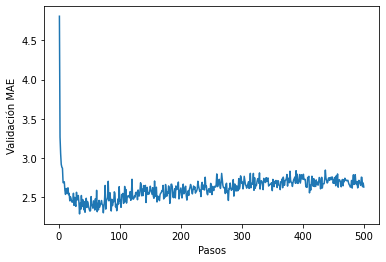

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(1,len(avg_mae_history)+1),avg_mae_history)
plt.xlabel('Pasos')
plt.ylabel('Validación MAE')
plt.show()

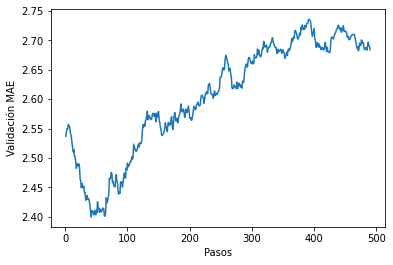

In [39]:
#trazamos de nuevo exluyendo los 10 primeros puntos de datos
#escalamos los valores para que sean cercanos y podamos visuzalizar una diferencia mas amplia.
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
      if smoothed_points:
        previous=smoothed_points[-1]
        smoothed_points.append(previous*factor+point*(1-factor))
      else:
        smoothed_points.append(point)
    return smoothed_points

smooth_mae_history=smooth_curve(avg_mae_history[10:])
plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Pasos')
plt.ylabel('Validación MAE')
plt.show()

###Entrenamos la red final

In [41]:
#como se observa en el caso anterior la red se sobreentrena despues de +- 80 pasos, por consiguiente se realiza:
net=build_network()
net.fit(train_data,train_targets,
        epochs=80,
        batch_size=16,
        verbose=0)
test_mse_score,test_mae_score=net.evaluate(test_data,test_targets)
test_mae_score #el resultado nos muestra que hay un margen de error de +- $2,650.

102/102 [==============================] - 0s 183us/step


2.654780387878418